# GAN for MNIST Tutorial

* Reference) ndb796/Deep-Learning-Paper-Review-and-Pratice [[link]](https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/GAN_for_MNIST_Tutorial.ipynb)
* 논문 제목: Generative Adversarial Networks(NIPS 2014)
* 가장 기본적인 GAN 모델을 학습해보는 실습을 진행합니다.
* 학습 데이터셋: MNIST(1 x 28 x 28)

---

# 필요한 라이브러리 불러오기

* 실습을 위한 Pytorch 라이브러리 불러옵니다.

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

# 생성자(Generator) 및 판별자(Discriminator) 모델 정의

In [ ]:
# letent vector를 뽑기 위한 noise distribution(uniform, normal 등)의 dimension
latent_dim = 100

# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # 배치 정규(batch normalization) 수행(차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))  # inplace: input으로 들어온 값 자체를 수정
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),   # 리스트를 *args로 푸는 문법
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh()   # -1부터 1 사이의 값
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img  # img.shape = (B, C, H, W)

In [ ]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output   # output.shape = (1,)

# 학습 데이터셋 불러오기

* 학습을 위해 MNIST 데이터셋을 불러옵니다.

In [ ]:
transforms_train = transforms.Compose([
                                       transforms.Resize(28),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root='./dataset', train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw


Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# 모델 학습 및 샘플링

* 학습을 위해 생성자와 판별자 모델을 초기화합니다.
* 적절한 하이퍼 파라미터를 설정합니다.

In [ ]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 손실 함수(loss function)
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 학습률(learing rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

* 모델을 학습하면서 주기적으로 샘플링하여 결과를 확인할 수 있습니다.

In [ ]:
# 학습 순서: G --> D(논문과는 다른 순서)

import time

n_epochs = 200  # 학습의 횟수(epoch) 변경
sample_interval = 2000  # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)   # 진짜(real): 1, real.shape = (B, 1)
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)   # 가짜(fake): 0, fake.shape = (B, 1)

        real_imgs = imgs.cuda()

        """생성자(generator)를 학습합니다."""
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()    # z.shape = (B, 100)

        # 이미지 생성
        generated_imgs = generator(z)   # generated_imgs.shape = (B, C, H, W)

        # 생성자(generator)의 손실(loss) 값 계산
        # 생성자: discriminator(generated_imgs)가 real로 판별할 수 있는 방향으로 학습
        g_loss = adversarial_loss(discriminator(generated_imgs), real)  # discriminator(generated_imgs).shape = (B, 1)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """판별자(discriminator)를 학습합니다."""
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        # 판별자: discriminator(real_imgs)는 real로 판별하고, discriminator(generated_imgs)는 fake로 판별할 수 있는 방향으로 학습
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 x 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f'{done}.png', nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    # G와 D는 saddle point로 학습이 이루어짐
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.541140] [G loss: 0.512860] [Elapsed time: 8.51s]
[Epoch 1/200] [D loss: 0.406639] [G loss: 1.105773] [Elapsed time: 16.85s]
[Epoch 2/200] [D loss: 0.576475] [G loss: 2.596328] [Elapsed time: 25.11s]
[Epoch 3/200] [D loss: 0.291485] [G loss: 1.791840] [Elapsed time: 33.47s]
[Epoch 4/200] [D loss: 0.385682] [G loss: 1.062364] [Elapsed time: 41.69s]
[Epoch 5/200] [D loss: 0.228376] [G loss: 2.111582] [Elapsed time: 49.86s]
[Epoch 6/200] [D loss: 0.653164] [G loss: 0.398740] [Elapsed time: 58.07s]
[Epoch 7/200] [D loss: 0.392946] [G loss: 0.784977] [Elapsed time: 66.08s]
[Epoch 8/200] [D loss: 0.547751] [G loss: 0.563963] [Elapsed time: 74.12s]
[Epoch 9/200] [D loss: 0.240741] [G loss: 1.513097] [Elapsed time: 82.39s]
[Epoch 10/200] [D loss: 0.239998] [G loss: 1.783767] [Elapsed time: 90.95s]
[Epoch 11/200] [D loss: 0.330105] [G loss: 4.388765] [Elapsed time: 99.20s]
[Epoch 12/200] [D loss: 0.321583] [G loss: 0.961211] [Elapsed time: 107.50s]
[Epoch 13/200] [D loss

* 생성된 이미지 예시를 출력합니다.

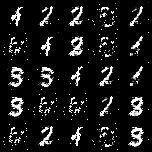

In [ ]:
from IPython.display import Image

Image('92000.png')